In [ ]:
from tensorflow import __version__
__version__

'2.15.0'

In [ ]:
import tensorflow as tf
from keras.datasets import boston_housing
import numpy as np

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [ ]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)

In [ ]:
import pandas as pd
df_train_data = pd.DataFrame(train_data)
df_train_target = pd.DataFrame(train_targets, columns=["target"])

pd.concat([df_train_data, df_train_target], axis=1).corr().style.background_gradient("Greens")

,0,1,2,3,4,5,6,7,8,9,10,11,12,target
0,1.000000,-0.192179,0.397419,-0.050828,0.405765,-0.217597,0.344410,-0.378590,0.609689,0.575652,0.273447,-0.390613,0.434384,-0.378498
1,-0.192179,1.000000,-0.533823,-0.041981,-0.521713,0.338683,-0.578728,0.650787,-0.311091,-0.303522,-0.403139,0.176006,-0.415237,0.380299
2,0.397419,-0.533823,1.000000,0.052839,0.774200,-0.409924,0.656350,-0.725155,0.599226,0.701362,0.379284,-0.372885,0.603129,-0.476743
3,-0.050828,-0.041981,0.052839,1.000000,0.079803,0.040431,0.080488,-0.083101,-0.024851,-0.051343,-0.122008,0.037832,-0.011017,0.168661
4,0.405765,-0.521713,0.774200,0.079803,1.000000,-0.335866,0.729338,-0.777062,0.616535,0.673471,0.188160,-0.409479,0.592994,-0.438328
5,-0.217597,0.338683,-0.409924,0.040431,-0.335866,1.000000,-0.240875,0.233970,-0.243990,-0.307904,-0.367256,0.145525,-0.610844,0.681483
6,0.344410,-0.578728,0.656350,0.080488,0.729338,-0.240875,1.000000,-0.766670,0.462188,0.512746,0.282193,-0.278403,0.590898,-0.364173
7,-0.378590,0.650787,-0.725155,-0.083101,-0.777062,0.233970,-0.766670,1.000000,-0.511179,-0.543668,-0.243067,0.295995,-0.507075,0.253900
8,0.609689,-0.311091,0.599226,-0.024851,0.616535,-0.243990,0.462188,-0.511179,1.000000,0.922676,0.449908,-0.478245,0.490250,-0.375515
9,0.575652,-0.303522,0.701362,-0.051343,0.673471,-0.307904,0.512746,-0.543668,0.922676,1.000000,0.440499,-0.471777,0.534752,-0.448737


## Analytic solv (normal equation)
$$W =(X^TX)^{-1} X^TY$$
$$b = \hat{Y} - WX^T$$

In [ ]:
# coef
coef = (np.linalg.inv(train_data.T @ train_data) ) @ train_data.T @ train_targets
coef

array([-1.10749194,  1.35308963,  0.02710126,  0.9943535 , -2.40156557,
        2.3962877 ,  0.2111952 , -3.47121628,  2.90814885, -1.95741889,
       -1.98298545,  0.81955092, -4.02739073])

In [ ]:
# intercept
intercept = train_targets.mean() - (coef @ train_data.T).mean()
intercept

22.39504950495051

In [ ]:
1 - (((coef @ train_data.T + intercept) - train_targets ) ** 2).mean() / (((train_targets.mean()) - train_targets ) ** 2).mean()

0.7399643695249464

In [ ]:
from sklearn.metrics import r2_score # use sklearn ready metrics
r2_score(train_targets, coef @ train_data.T + intercept), r2_score(test_targets, coef @ scaler.transform(test_data).T + intercept)

(0.7399643695249463, 0.7213535934621509)

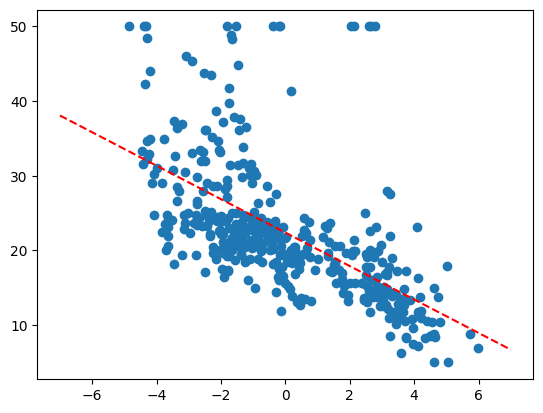

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=1) # we can reduce data dimensionality for visualization
pca_data_vs = pca.fit_transform(train_data)

plt.scatter(pca_data_vs, train_targets);
plt.plot(
  np.linspace(-7, 7, 100),
  pca.transform(
  coef.reshape(1, -1)).ravel() * np.linspace(-7, 7, 100) + intercept,
  c="r",
  ls="--"
  );

In [ ]:
from sklearn.linear_model import LinearRegression
# In sklearn linear regression has automatic standartize scaler
lg = LinearRegression()
lg.fit(train_data, train_targets)

LinearRegression()

In [ ]:
lg.score(train_data, train_targets), lg.score(scaler.transform(test_data), test_targets)

(0.7399643695249463, 0.7213535934621552)

In [ ]:
lg.coef_, lg.intercept_ # we have the same solution

(array([-1.10749194,  1.35308963,  0.02710126,  0.9943535 , -2.40156557,
         2.3962877 ,  0.2111952 , -3.47121628,  2.90814885, -1.95741889,
        -1.98298545,  0.81955092, -4.02739073]),
 22.39504950495051)

## Solution with **Gradient Descent**
to start, let's get acquainted 3 form of Gradient Descent
## Gradient Descent Methods

- **Batch Gradient Descent** computes the gradient of the cost function using the entire dataset, leading to a stable but potentially slow convergence.

- **Stochastic Gradient Descent (SGD)** updates the model parameters using only a single training example at each iteration, which can result in faster convergence but higher variance in the updates.

- **Mini-Batch Gradient Descent** is a compromise between Batch and Stochastic Gradient Descent, using a small subset of the dataset (mini-batch) for each update, balancing between stability and speed.


In [ ]:
def batch_GD(X, y, w, b, learning_rate):
  n = X.shape[0]
  dw = X.T @ (w @ X.T  + b - y)
  db = (w @ X.T  + b - y).sum()
  w -= learning_rate * dw / n
  b -= learning_rate * db / n
  return w, b


def learning_schedule(t, t0: int = 5, t1: int = 50):
  return t0 / (t + t1)


def stochastic_GD(X, y, w, b, epoch):
  n = X.shape[0]
  for i in range(n):
    r = np.random.randint(n)
    px, py = X[r:r+1], y[r:r+1]
    dw = px.T @ (w @ px.T + b - py)
    db = (w @ px.T + b - py).sum()
    learning_rate = learning_schedule(i + epoch * n)
    w -= learning_rate * dw
    b -= learning_rate * db
  return w, b

In [ ]:
# Batch Gradient Descent
learning_rate = 0.1
epoch = 1000
X, y = train_data.copy(), train_targets.copy()
m = X.shape[1]
w, b = np.full(m, 0.5), 0.5

for e in range(epoch):
  w, b = batch_GD(X, y, w, b, learning_rate)
w, b

(array([-1.10717463,  1.35237005,  0.02529524,  0.99466402, -2.40151994,
         2.39668833,  0.210649  , -3.4716424 ,  2.90219153, -1.95077482,
        -1.98279702,  0.81946292, -4.02712942]),
 22.395049504950496)

In [ ]:
# Stochastic Gradient Descent
epoch = 1000
X, y = train_data.copy(), train_targets.copy()
m = X.shape[1]
w, b = np.full(m, 0.5), 0.5

for e in range(epoch):
  w, b = stochastic_GD(X, y, w, b, e)
w, b

(array([-1.11197611,  1.36812252,  0.09880617,  0.96120902, -2.4063617 ,
         2.37634992,  0.23036681, -3.45077095,  3.12415983, -2.22393052,
        -1.98759348,  0.80172675, -3.99731694]),
 22.4077186564424)

As we can see, stochastic gradient descent does not provide as accurate results because it is not stable. However, it has advantages such as not getting stuck in local minima and having a higher chance of finding the global minimum.


## Tenserflow analog

In [ ]:
import tensorflow as tf
n = train_data.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(n, ))
])

model.compile(optimizer='sgd', loss='mean_squared_error')


In [ ]:
history = model.fit(train_data, train_targets, epochs=100, validation_data=(scaler.transform(test_data), test_targets))

Epoch 1/100
13/13 [==============================] - 1s 33ms/step - loss: 461.3260 - val_loss: 340.5245
Epoch 2/100
13/13 [==============================] - 0s 7ms/step - loss: 277.4942 - val_loss: 207.7662
Epoch 3/100
13/13 [==============================] - 0s 7ms/step - loss: 173.8019 - val_loss: 131.7068
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 113.0247 - val_loss: 85.6067
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 76.8997 - val_loss: 58.1056
Epoch 6/100
13/13 [==============================] - 0s 7ms/step - loss: 55.6689 - val_loss: 43.2904
Epoch 7/100
13/13 [==============================] - 0s 11ms/step - loss: 42.7994 - val_loss: 34.5526
Epoch 8/100
13/13 [==============================] - 0s 7ms/step - loss: 35.2848 - val_loss: 28.9368
Epoch 9/100
13/13 [==============================] - 0s 7ms/step - loss: 30.5628 - val_loss: 24.6711
Epoch 10/100
13/13 [==============================] - 0s 7ms/step - loss: 27.9305 

In [ ]:
# Получение весов и смещений из первого (и единственного) слоя
weights, biases = model.layers[0].get_weights()

print(f'Weights: {weights}')
print(f'Biases: {biases}')


Weights: [[-1.0920247 ]
 [ 1.2938792 ]
 [-0.13442141]
 [ 1.0121812 ]
 [-2.3700361 ]
 [ 2.4550517 ]
 [ 0.17143019]
 [-3.4724493 ]
 [ 2.3911765 ]
 [-1.4276768 ]
 [-1.9868352 ]
 [ 0.8255209 ]
 [-4.0246263 ]]
Biases: [22.400093]


In [ ]:
r2_score(train_targets, model.predict(train_data)), r2_score(test_targets, model.predict(scaler.transform(test_data)))

4/4 [==============================] - 0s 2ms/step


(0.7394362569828093, 0.7250637762815586)

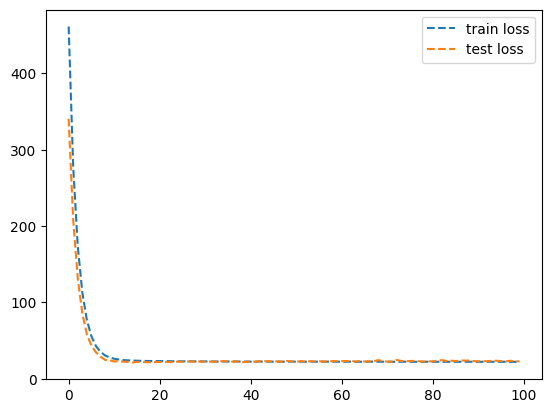

In [ ]:
plt.plot(history.history["loss"], label="train loss", ls="--")
plt.plot(history.history["val_loss"], label="test loss", ls="--")
plt.legend();